## Imports

In [5]:
import rospy
import time
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, Layout
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from tf import transformations
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from matplotlib.animation import FuncAnimation
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalStatusArray

%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

## Modality Selection

In [6]:
rospy.init_node("jupyter_ui")
output = widgets.Output()


des_x = widgets.FloatText(
    value=0,
    description='X:',
    disabled=False
)
des_y = widgets.FloatText(
    value=0,
    description='Y:',
    disabled=False
)

boxes = widgets.HBox([des_x, des_y])

cancel_button = widgets.Button(description = 'Click Me to cancel the goal!', layout=Layout(width='50%', height='80px'), button_style='danger')

def cancel_button_clicked(b):
    rospy.set_param('active', 0)
    
    
cancel_button.on_click(cancel_button_clicked)
    
ok_button = widgets.Button(description = 'Send Goal', layout=Layout(width='30%', height='30px'), button_style='')

def ok_button_clicked(b):

    rospy.set_param('active', 0)
    rospy.set_param('des_pos_x', des_x.value)
    rospy.set_param('des_pos_y', des_y.value)
    rospy.set_param('active', 1) 
    
ok_button.on_click(ok_button_clicked)
    
button_first_mod = widgets.Button(description = 'Click Me to choose the first modality!', layout=Layout(width='50%', height='80px'), button_style='info')
def first_button_clicked(b):
    print("You chose the first controlling modality")
    display(des_x)
    display(des_y)
    display(ok_button)
    display(cancel_button)
    
button_first_mod.on_click(first_button_clicked)

button_second_mod = widgets.Button(description = 'Click Me to choose the second modality!', layout=Layout(width='50%', height='80px'), button_style='info')
def second_button_clicked(b):
    
    print("You chose the second controlling modality, use the 'my_teleop_twist_keyboard' xterm terminal to control the robot")
    rospy.set_param('active', 0)
    rospy.set_param('active', 2)
button_second_mod.on_click(second_button_clicked)

button_third_mod = widgets.Button(description = 'Click Me to choose the third modality!', layout=Layout(width='50%', height='80px'), button_style='info')
def third_button_clicked(b):

    print("You chose the third controlling modality, use the 'my_teleop_twist_keyboard' xterm terminal to control the robot")
    rospy.set_param('active', 0)
    rospy.set_param('active', 3)
    
button_third_mod.on_click(third_button_clicked)


buttons = widgets.HBox([button_first_mod, button_second_mod, button_third_mod])
widgets.VBox([buttons, output])
    


You chose the first controlling modality


FloatText(value=0.0, description='X:')

FloatText(value=0.0, description='Y:')

Button(description='Send Goal', layout=Layout(height='30px', width='30%'), style=ButtonStyle())

Button(button_style='danger', description='Click Me to cancel the goal!', layout=Layout(height='80px', width='…

## Data visualization. 
### Robot position, Sensor Array and Reached Goals 

<IPython.core.display.Javascript object>


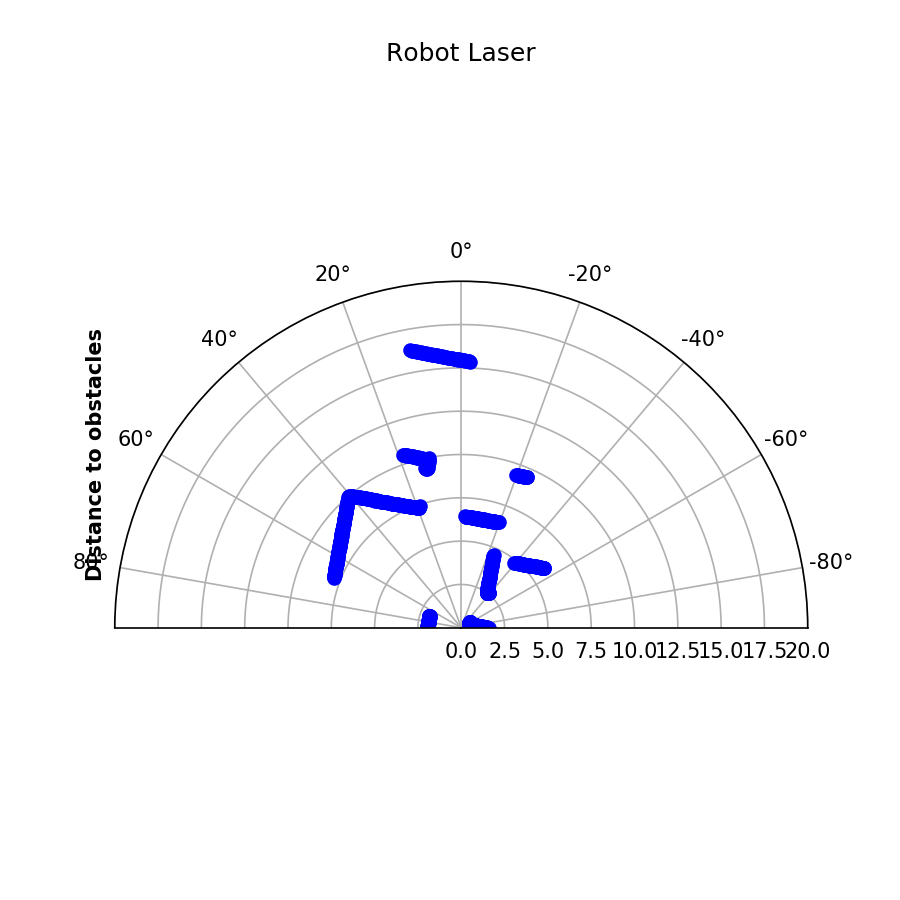

<IPython.core.display.Javascript object>


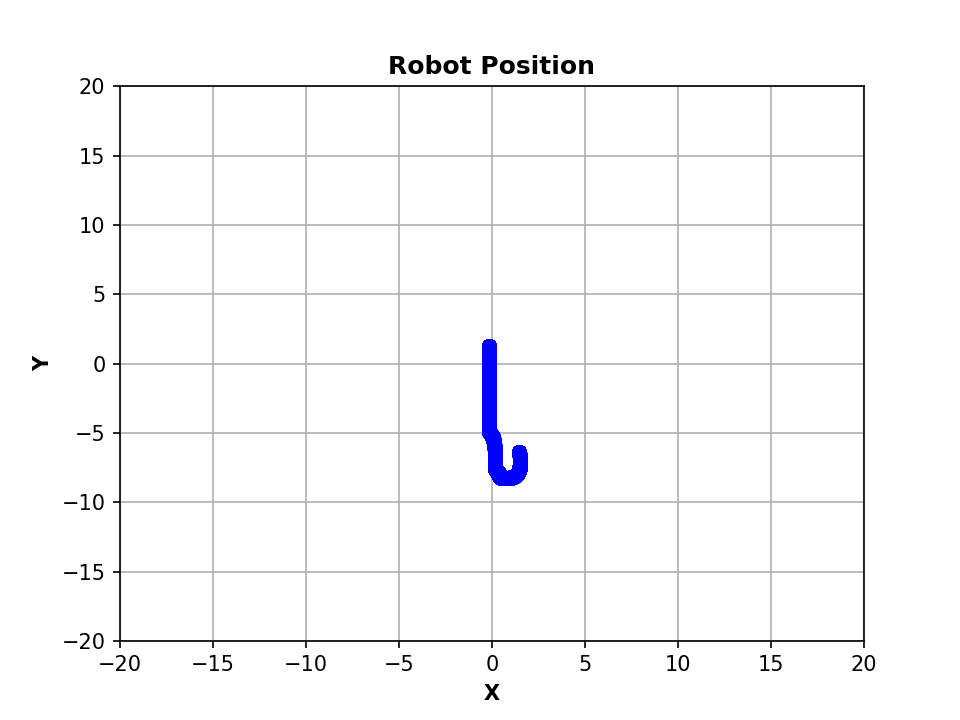

<IPython.core.display.Javascript object>


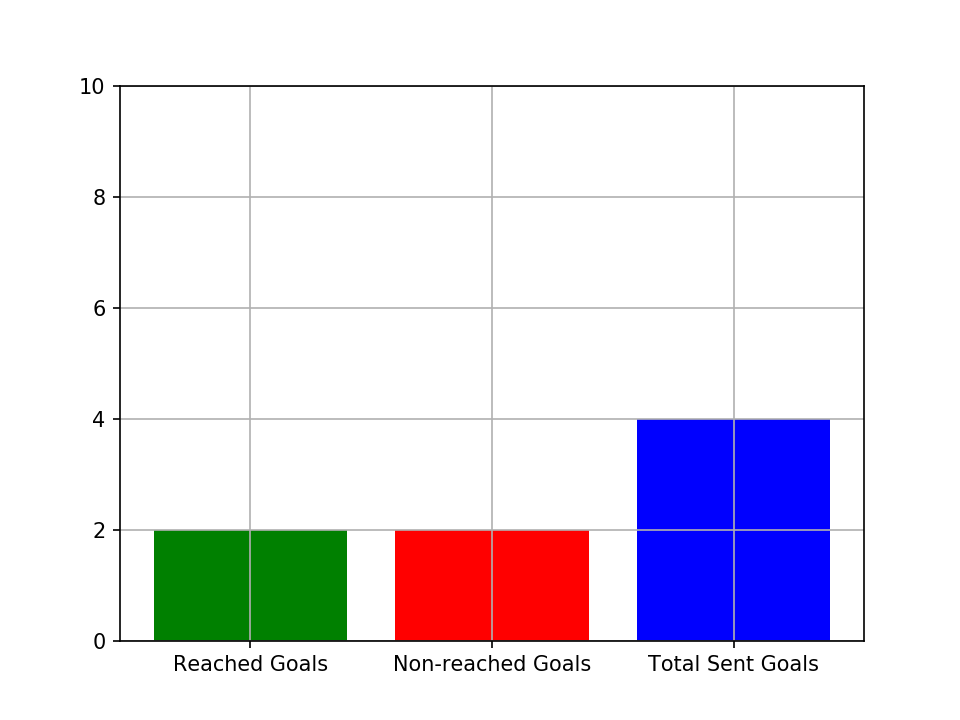

In [7]:
angles = []

class Visualiser:
    def __init__(self):
        
        self.fig_laser = plt.figure(figsize=(6,6))
        self.ax_laser = plt.subplot(111, polar=True)
        self.ax_laser.set_thetalim(-np.pi/2,np.pi/2)
        self.ax_laser.set_theta_zero_location("N")
       
        self.ln_laser, = self.ax_laser.plot([],[],'bo')
        
        
        self.fig_odom, self.ax_odom = plt.subplots()
        plt.grid(True)
        self.ln_odom, = plt.plot([] ,[], 'bo')
        
        self.achieved = False
        self.goal_counter = 0
        self.non_reached_goal_counter = 0
        self.laser  = [] 
        self.x_pos, self.y_pos = [], []

        self.fig_target, self.ax_target = plt.subplots()
        plt.grid(True)
        self.status_list = [0, 0]
        self.data = {'Reached Goals': self.goal_counter, 
                     'Non-reached Goals':self.non_reached_goal_counter, 
                     'Total Sent Goals': self.goal_counter + self.non_reached_goal_counter}
        
        self.target = list(self.data.keys())
        self.values = list(self.data.values())
        self.ln_target = plt.bar(self.target, self.values, color=("green", "red", "blue"))
        
              
    def plot_init(self):
        
        
        self.ax_laser.set_title("Robot Laser")
        self.ax_laser.set_ylabel("Distance to obstacles",fontweight="bold")
        
        self.ax_odom.set_xlim(-20, 20)
        self.ax_odom.set_ylim(-20, 20)

        self.ax_odom.set_title("Robot Position",fontweight="bold")
        self.ax_odom.set_ylabel("Y",fontweight="bold")
        self.ax_odom.set_xlabel("X",fontweight="bold")

        self.ax_target.set_ylim(0, 10)
        
        return self.ln_laser , self.ln_odom, self.ln_target
    
    def scan_callback(self, msg):
        global angles
        angles = list(np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment))
        self.laser=list(msg.ranges)
        
    def odom_callback(self, msg):
        self.y_pos.append(msg.pose.pose.position.y)
        self.x_pos.append(msg.pose.pose.position.x)
        
    def goal_cb(self, msg): 

        try: 

            self.status_list.append(msg.status_list[0].status)

            if self.status_list[-1] == 3 and self.status_list[-2] != 3:
                self.goal_counter = self.goal_counter + 1

            elif self.status_list[-1] == 2 and self.status_list[-2] != 2:
                self.non_reached_goal_counter = self.non_reached_goal_counter + 1

            elif self.status_list[-1] == 4 and self.status_list[-2] != 2:
                self.non_reached_goal_counter = self.non_reached_goal_counter + 1

        except IndexError:
            pass
            
        
    
    def update_plot_odom(self, frame):
        x = self.x_pos
        y = self.y_pos
        self.ln_odom.set_data(x, y)
        return self.ln_odom
    
    def update_plot_target(self, frame):
        x = self.goal_counter
        y = self.non_reached_goal_counter
        z = self.goal_counter + self.non_reached_goal_counter
        self.updated_data = {'Reached Goals': x, 
                             'Non-reached Goals': y, 
                             'Total Sent Goals': z}
        
        h = list(self.updated_data.values())
        q = list(self.updated_data.keys())
        
        self.ln_target = plt.bar(q, h, color=("green", "red", "blue"))
        
        return self.ln_target
    
    def update_polar(self, frame):
        global angles    
        self.ax_laser.set_rmax(20)
        self.ln_laser.set_data(angles,self.laser)
        return self.ln_laser
    

    
vis = Visualiser()
sub_scan = rospy.Subscriber("/scan", LaserScan, vis.scan_callback)
sub_odom = rospy.Subscriber("/odom", Odometry, vis.odom_callback)
sub_status = rospy.Subscriber("/move_base/status", GoalStatusArray, vis.goal_cb)

ani_laser = FuncAnimation(vis.fig_laser, vis.update_polar, blit = True)
ani_odom = FuncAnimation(vis.fig_odom, vis.update_plot_odom, init_func=vis.plot_init)
ani_target = FuncAnimation(vis.fig_target, vis.update_plot_target, init_func=vis.plot_init, interval=100)

plt.show(block = True)